In [1]:
import sys
import os
import struct
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code'))
from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_plotting_defaults()
from utils import roi_utils, nsd_utils, default_paths, stats_utils

In [6]:
# Load results of the fitting procedure

subject = 1
volume_space=True
# fitting_type = 'texture_pyramid_ridge_4ori_4sf'
fitting_type = 'texture_pyramid_ridge_4ori_4sf_pca_HL'
# fitting_type = 'texture_pyramid_ridge_4ori_4sf_pca_LL_pca_HL'

root = os.path.dirname(os.path.dirname(os.getcwd()))
out, fig_save_folder = load_fits.load_fit_results(subject, volume_space, fitting_type, \
                                                  n_from_end=0, root=root, verbose=True);
load_fits.print_output_summary(out)

if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

loading from /user_data/mmhender/imStat/model_fits/S01/texture_pyramid_ridge_4ori_4sf_pca_HL/Nov-18-2021_1339_17/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_type', 'fitting_type2', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'aperture', 'aperture_rf_range', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'zscore_in_groups', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'corr_each_feature', 'discrim_each_axis', 'min_pct_var', 'max_pc_to_retain_pyr_ll', 'max_pc_to_retain_pyr_hl', 'use_pca_pyr_feats_ll', 'use_pca_pyr_feats_hl', 'feature_info', 'group_all_hl_feats'])
subject = 1
volume_space = 1
fitting_type = pyramid_texture
voxel_mask: shape (699192,)
brain_nii_shape: shape (3,)
image_order: shape (30000,)
voxel_index: len 1
voxel_roi: len 4
voxel_ncsnr: shape (699

In [7]:
# roi_def = roi_utils.get_combined_rois(subject,include_all=False,include_body=False,volume_space=True,verbose=False) 
roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=True,volume_space=True,verbose=False) 

skip_inds = [10,11,15,23]
retlabs, facelabs, placelabs, bodylabs, \
        ret_names, face_names, place_names, body_names = roi_def


In [ ]:
port=33333
summary_plots.plot_summary_pycortex(out=out, subject=subject, fitting_type=fitting_type, \
                                port=port, roi_def=roi_def)

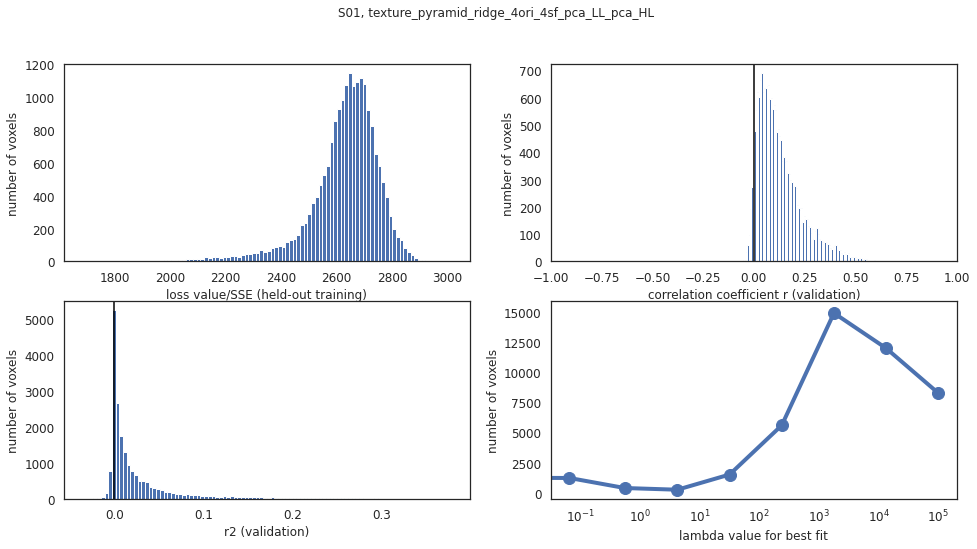

In [4]:
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_perf_summary(subject, fitting_type, out, fig_save_folder=fig_save_folder)

In [88]:
lambdas = np.logspace(0.,5.,9, dtype=np.float32)
lambdas

array([1.0000000e+00, 4.2169652e+00, 1.7782795e+01, 7.4989418e+01,
       3.1622775e+02, 1.3335215e+03, 5.6234131e+03, 2.3713736e+04,
       1.0000000e+05], dtype=float32)

In [90]:
np.exp(np.log(100000))

100000.00000000001

In [92]:
lambdas = np.logspace(np.log(0.01),np.log(10**5+0.01),9, dtype=np.float32, base=np.e) - 0.01
lambdas

array([0.0000000e+00, 6.4989425e-02, 5.5234134e-01, 4.2069650e+00,
       3.1612778e+01, 2.3712740e+02, 1.7782695e+03, 1.3335206e+04,
       1.0000000e+05], dtype=float32)

In [7]:
summary_plots.plot_summary_pycortex(subject, fitting_type, out, roi_def=roi_def, port=33333)

Data is in 3d volume space
navigate browser to: 127.0.0.1:33333
Started server on port 33333


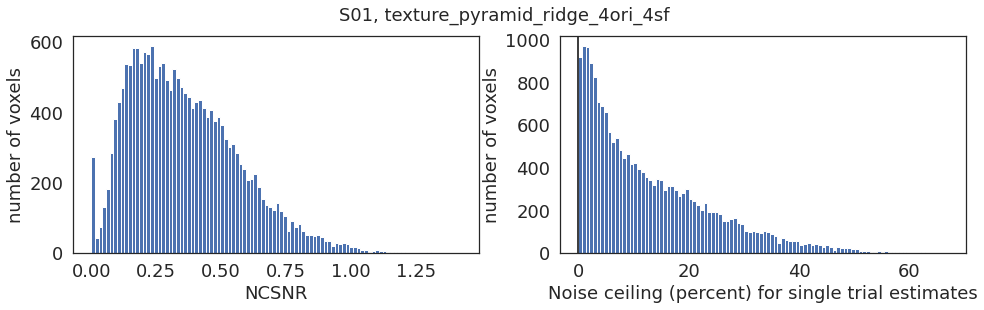

In [24]:
plot_utils.set_all_font_sizes(fs = 18)
summary_plots.plot_noise_ceilings(subject, fitting_type,out, fig_save_folder)

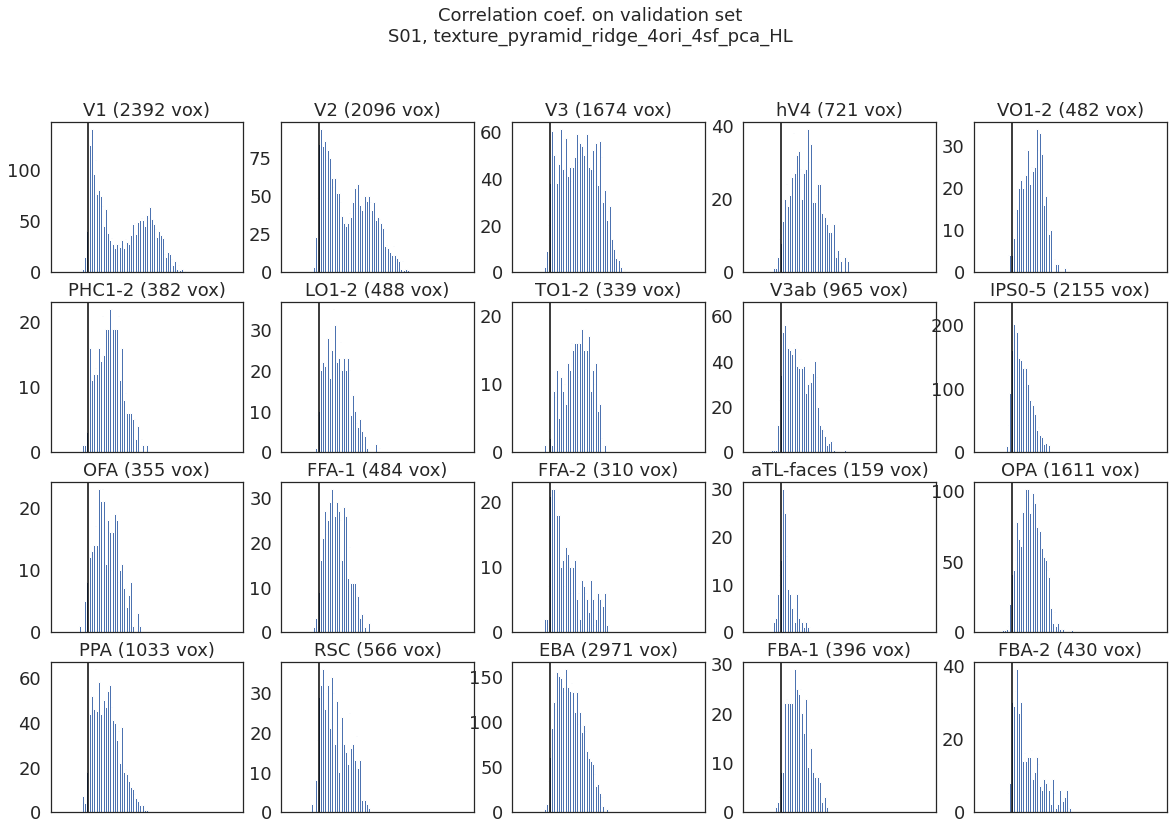

In [67]:
plot_utils.set_all_font_sizes(fs = 18)
summary_plots.plot_cc_each_roi(subject, fitting_type,out, roi_def=roi_def, skip_inds=skip_inds, \
                               fig_save_folder=fig_save_folder)

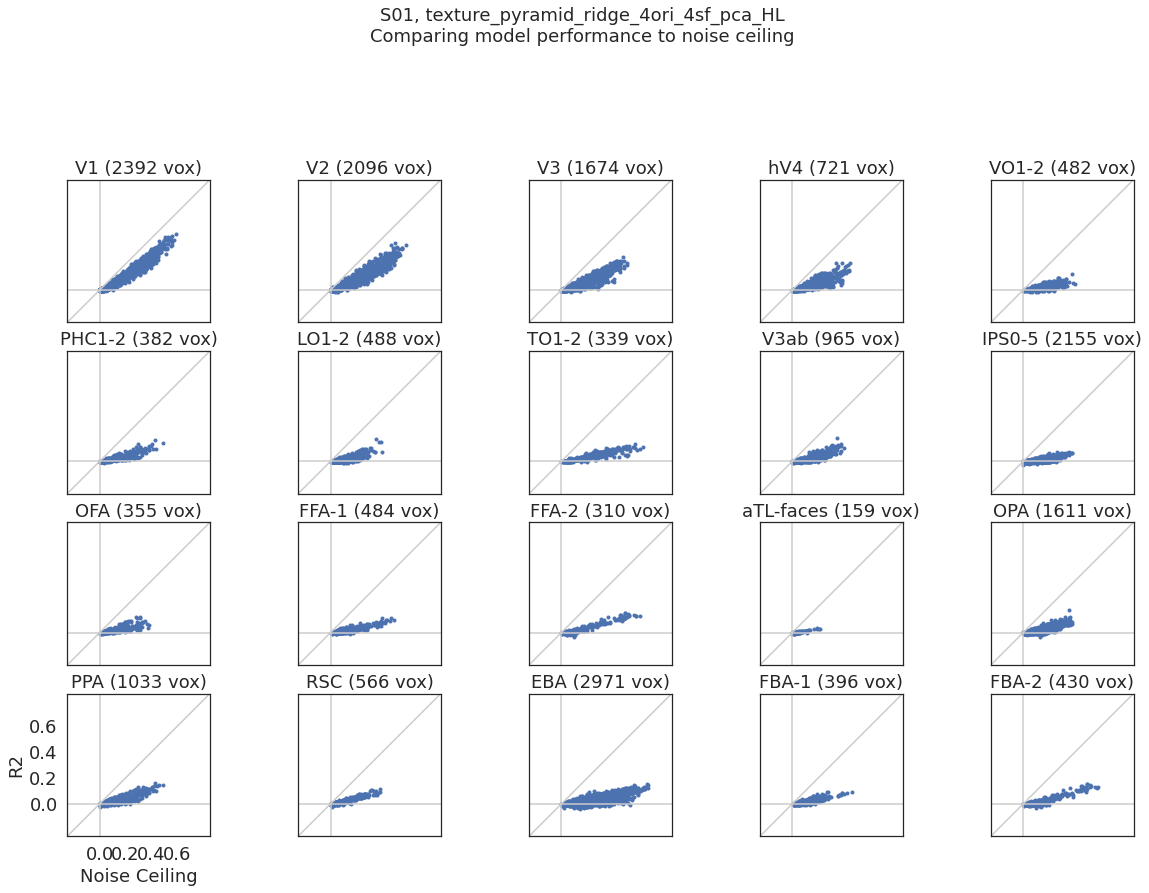

In [68]:
plot_utils.set_all_font_sizes(fs = 18)
summary_plots.plot_r2_vs_nc(subject, fitting_type,out, roi_def=roi_def, skip_inds=skip_inds, \
                            axlims = [-0.25, 0.85], fig_save_folder=fig_save_folder, fig_size=(20,24))

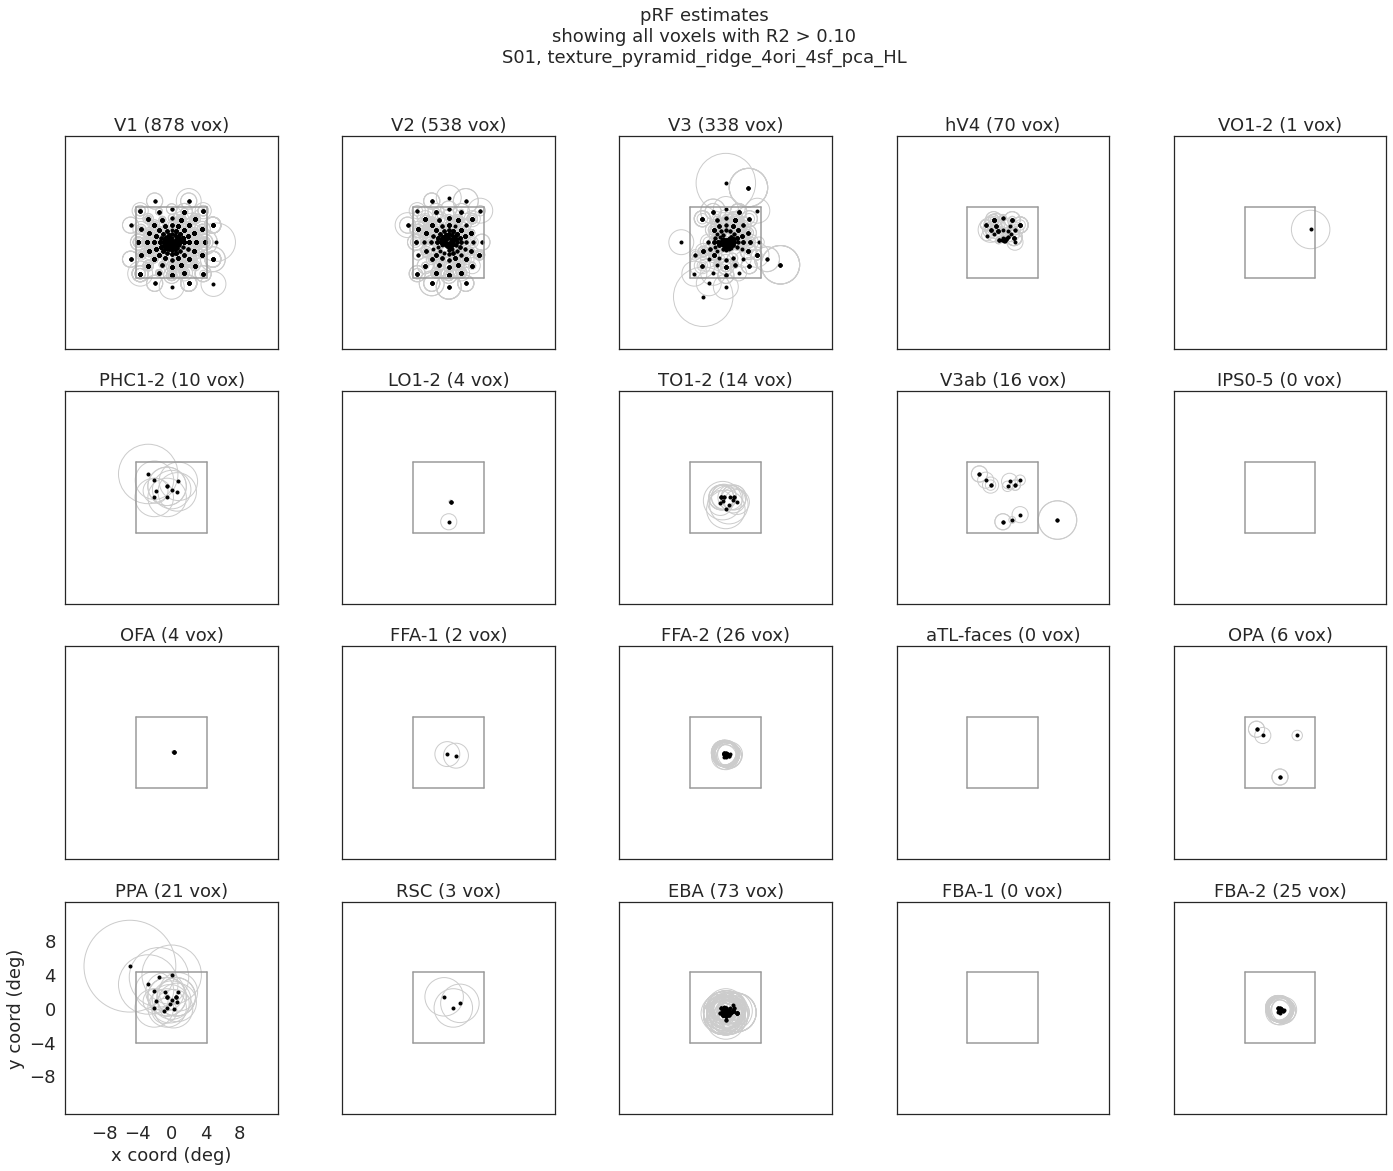

In [69]:
plot_utils.set_all_font_sizes(fs = 18)
plot_prf_params.plot_spatial_rf_circles(subject, fitting_type,out, roi_def=roi_def, skip_inds=skip_inds,\
                                     r2_cutoff = 0.10, fig_save_folder=fig_save_folder)

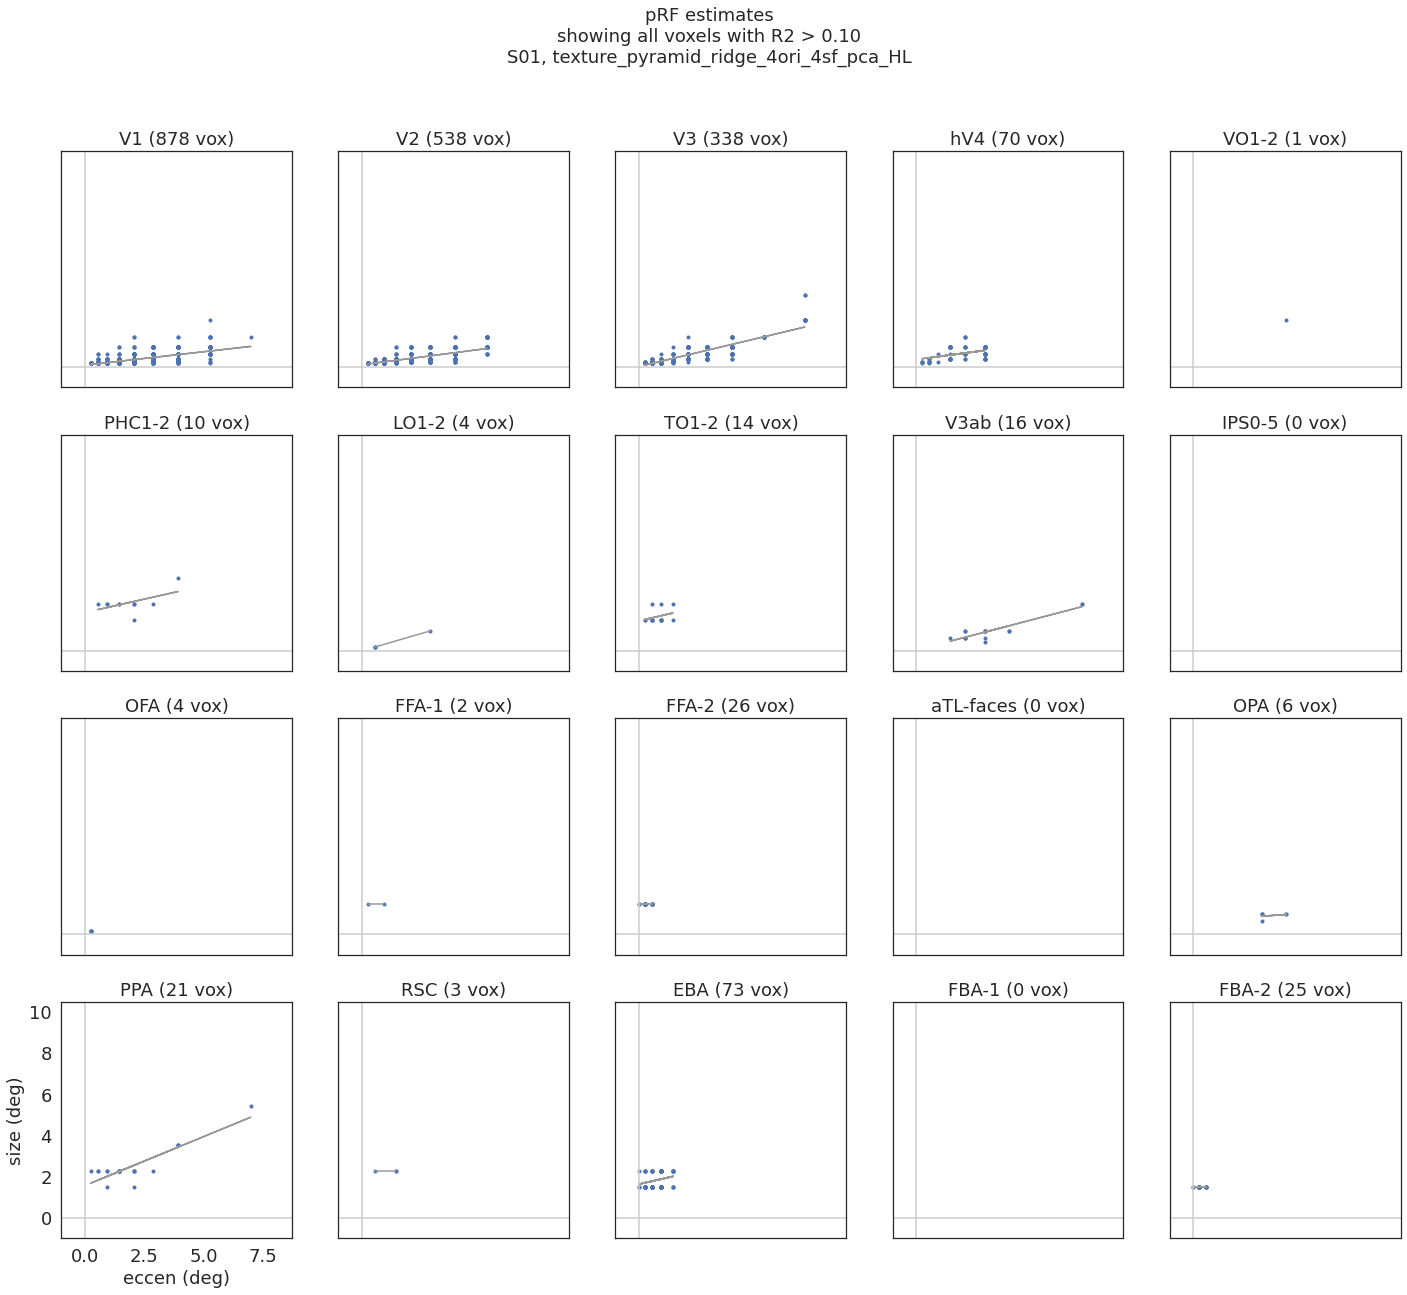

In [70]:
plot_utils.set_all_font_sizes(fs = 18)
plot_prf_params.plot_size_vs_eccen(subject, fitting_type, out, roi_def=roi_def, skip_inds=skip_inds, \
                                   r2_cutoff=0.10, fig_save_folder=fig_save_folder)

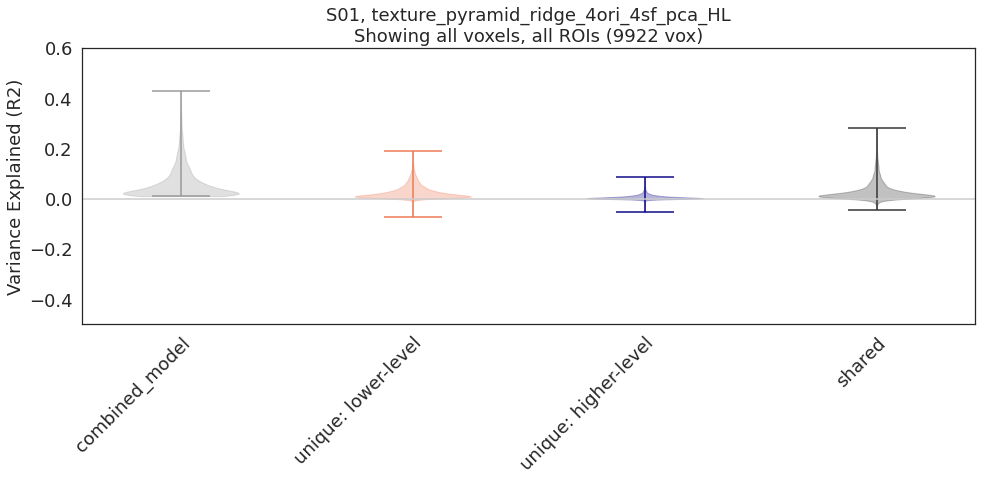

In [77]:
pp0 = 0
pp1 = 1
pp2 = 2

name1 = out['partial_version_names'][pp1][5:]
name2 = out['partial_version_names'][pp2][5:]
val_r2 = out['val_r2']
ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

colors = cm.plasma(np.linspace(0,1,4))
colors = np.flipud(colors)
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[[1,3],:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

inds2use = val_r2[:,0]>0.01
# inds2use = np.ones(np.shape(val_r2[:,0]))==1

vp = plot_utils.violin_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                 title='S%02d, %s\nShowing all voxels, all ROIs (%d vox)'%(subject, fitting_type, \
                                                        np.sum(inds2use)), \
                                                        horizontal_line_pos=0, ylims=[-0.50, 0.60])
vp.create(data=var_expl[inds2use,:], new_fig=True)

plt.gcf().subplots_adjust(bottom=0.4)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_violin_allrois.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_violin_allrois.png'))

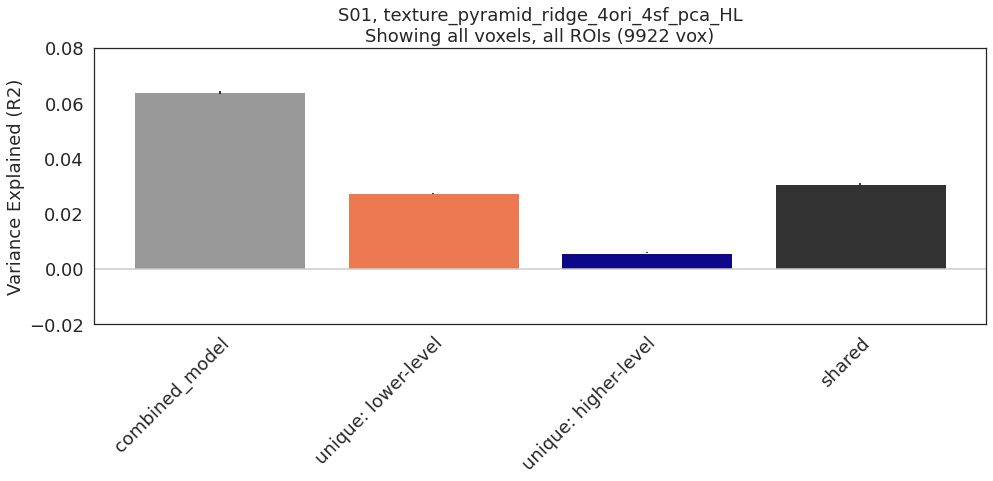

In [79]:
pp0 = 0
pp1 = 1
pp2 = 2

name1 = out['partial_version_names'][pp1][5:]
name2 = out['partial_version_names'][pp2][5:]
val_r2 = out['val_r2']
ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

colors = cm.plasma(np.linspace(0,1,4))
colors = np.flipud(colors)
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[[1,3],:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

inds2use = val_r2[:,0]>0.01

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                 title='S%02d, %s\nShowing all voxels, all ROIs (%d vox)'%(subject, fitting_type, \
                                                        np.sum(inds2use)), \
                                                        horizontal_line_pos=0, ylims=[-0.02, 0.08])
bp.create(data=var_expl[inds2use,:], new_fig=True)

plt.gcf().subplots_adjust(bottom=0.4)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_bars_allrois.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_bars_allrois.png'))

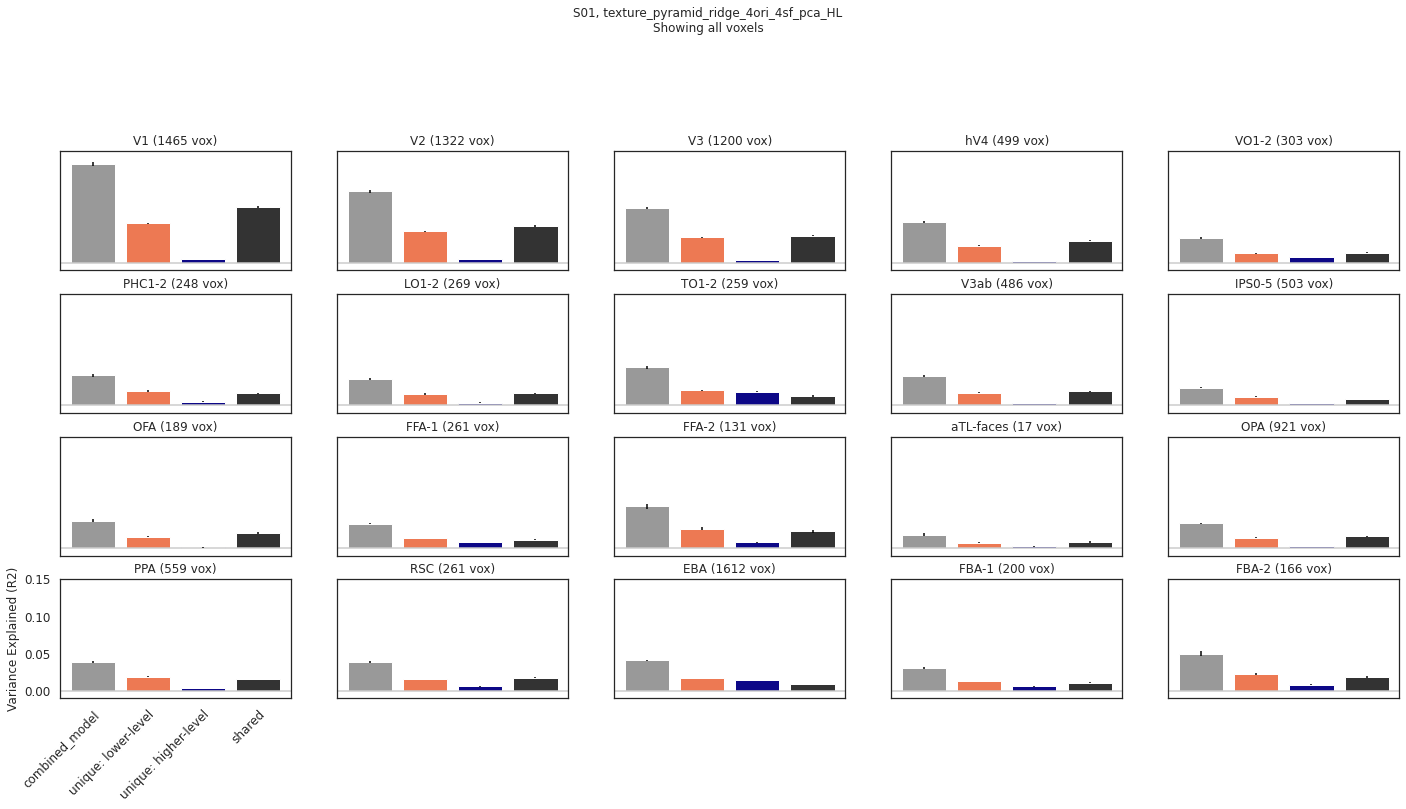

In [8]:
pp0 = 0
pp1 = 1
pp2 = 2

name1 = out['partial_version_names'][pp1][5:]
name2 = out['partial_version_names'][pp2][5:]
val_r2 = out['val_r2']
ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

colors = cm.plasma(np.linspace(0,1,4))
colors = np.flipud(colors)
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[[1,3],:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

inds2use = val_r2[:,0]>0.01

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.01, 0.15])
plot_utils.create_roi_subplots(var_expl, inds2use, bp, subject, out, roi_def=roi_def, \
                               skip_inds=skip_inds,\
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type))

plt.gcf().subplots_adjust(bottom=0.5)

if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_bars_eachroi.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_bars_eachroi.png'))

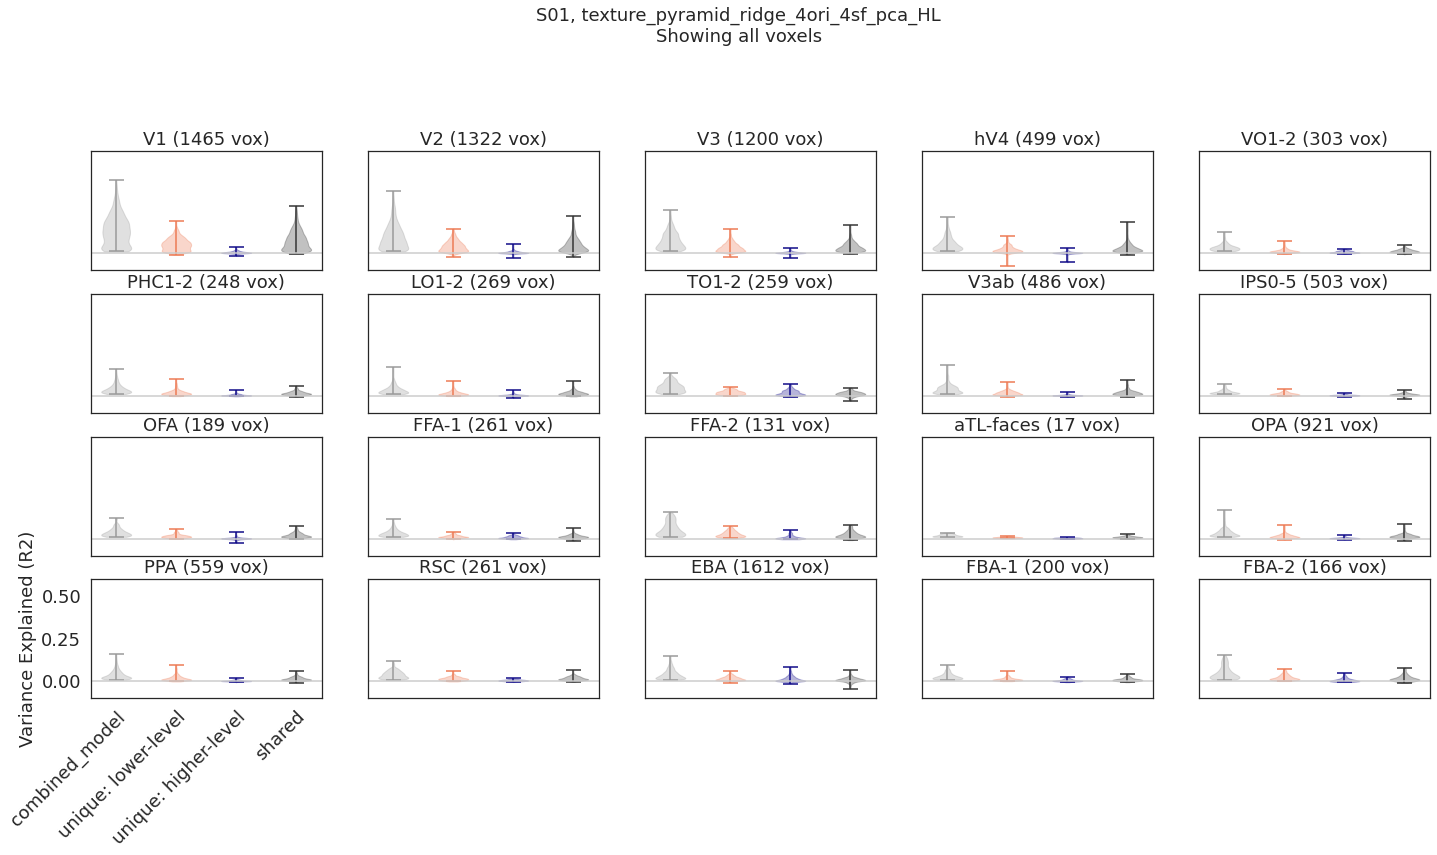

In [84]:
pp0 = 0
pp1 = 1
pp2 = 2

name1 = out['partial_version_names'][pp1][5:]
name2 = out['partial_version_names'][pp2][5:]
val_r2 = out['val_r2']
ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

colors = cm.plasma(np.linspace(0,1,4))
colors = np.flipud(colors)
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[[1,3],:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

inds2use = val_r2[:,0]>0.01

vp = plot_utils.violin_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.10, 0.60])
plot_utils.create_roi_subplots(var_expl, inds2use, vp, subject, out, roi_def=roi_def, \
                               skip_inds=skip_inds,\
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type))

plt.gcf().subplots_adjust(bottom=0.5)

if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_violin_eachroi.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_violin_eachroi.png'))

In [4]:
# Make plots in pycortex for variance partitioning analysis

import cortex

port=33333

pp0 = 0
pp1 = 1
pp2 = 2

name1 = out['partial_version_names'][pp1][5:]
name2 = out['partial_version_names'][pp2][5:]
val_r2 = out['val_r2']
ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

max_ind = np.argmax(var_expl[:,1:3], axis=1)

maps = [max_ind+1] + [var_expl[:,fi] for fi in range(var_expl.shape[1])]

names = ['Prefered feature type (based on unique var)'] + ve_names

cmaps = ['plasma_r', 'PuBu', 'PuBu', 'PuBu', 'PuBu']
mins = [0,0,0,0,0]
maxes = [2, 0.4, 0.10, 0.10, 0.2]

plot_utils.plot_maps_pycortex(maps, names, subject, out, roi_def=roi_def, fitting_type=fitting_type, \
                              port=port, cmaps=cmaps, mins=mins, maxes=maxes)

Data is in 3d volume space
navigate browser to: 127.0.0.1:33333
Started server on port 33333
Stopping server


In [28]:
# Make plots in pycortex for variance partitioning analysis

import cortex

port=33333
# var_expl, ve_names = analysis_utils.process_two_way_var_part(out)
# max_ind = np.argmax(var_expl[:,1:3], axis=1)

# maps = [max_ind+1] + [var_expl[:,fi] for fi in range(var_expl.shape[1])]

# names = ['Prefered feature type (based on unique var)'] + ve_names
names = ['Full Model'] + ['Unique_' + ff for ff in out['feature_info'][1]]
maps = [out['val_cc'][:,0]] + [out['val_cc'][:,ff] - out['val_cc'][:,0] for ff in np.arange(1,out['val_cc'].shape[1])]
cmaps = ['PuBu']
mins = [0]
maxes = [0.2]

plot_utils.plot_maps_pycortex(maps, names, subject, out, fitting_type, port, cmaps=cmaps, mins=mins, maxes=maxes)

Data is in 3d volume space


IndexError: list index out of range

In [74]:
plot_utils.set_all_font_sizes(fs = 18)
r2_cutoff = 0.010
val_r2 = out['val_r2']
ff_inds = np.arange(15,29)
n_submodels = len(ff_inds)

# Compute variance explained by each feature type - how well does the model without that feature type
# do, compared to the model with all features? 
# (subtract later columns from the first column)
var_expl = np.tile(np.expand_dims(val_r2[:,0], axis=1), [1,n_submodels]) - val_r2[:,ff_inds] 
var_expl = np.concatenate([val_r2[:,0:1], var_expl], axis=1)
ve_names = ['Full Model'] + ['Unique_' + out['partial_version_names'][ff][10:] \
                             for ff in ff_inds]

colors = cm.plasma(np.linspace(0,1,len(ve_names)-1))
graycolor = np.array([0.6, 0.6, 0.6, 1])
colors = np.concatenate((graycolor[np.newaxis,:], np.flipud(colors)), axis=0)

inds2use = out['val_r2'][:,0]>r2_cutoff

vp = plot_utils.violin_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                 title='S%02d, %s\nShowing all voxels with R2 > %.2f, all ROIs (%d vox)'%(subject, fitting_type, \
                                                        r2_cutoff, np.sum(inds2use)), \
                                                        horizontal_line_pos=0, ylims=[-0.45, 0.55])
vp.create(data=var_expl[inds2use,:], new_fig=True)

plt.gcf().subplots_adjust(bottom=0.4)

if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'violin_uniq_var_texturefeat_allrois.png'))
    plt.savefig(os.path.join(fig_save_folder,'violin_uniq_var_texturefeat_allrois.pdf'))


IndexError: index 15 is out of bounds for axis 1 with size 3

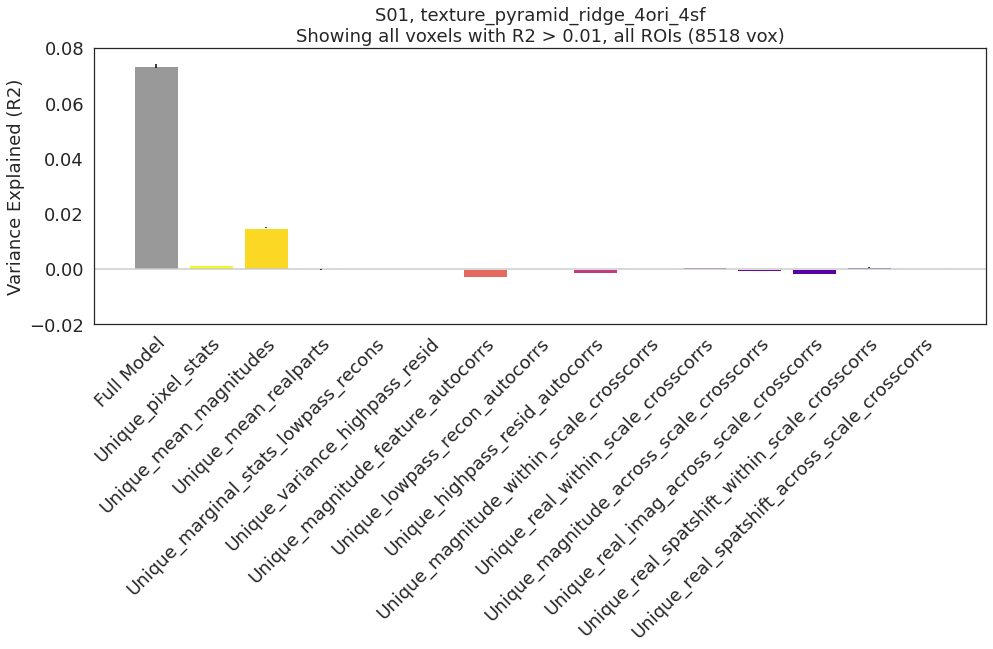

In [44]:
r2_cutoff=0.01

plot_utils.set_all_font_sizes(fs = 18)
val_r2 = out['val_r2']
ff_inds = np.arange(15,29)
n_submodels = len(ff_inds)

# Compute variance explained by each feature type - how well does the model without that feature type
# do, compared to the model with all features? 
# (subtract later columns from the first column)
var_expl = np.tile(np.expand_dims(val_r2[:,0], axis=1), [1,n_submodels]) - val_r2[:,ff_inds] 
var_expl = np.concatenate([val_r2[:,0:1], var_expl], axis=1)
ve_names = ['Full Model'] + ['Unique_' + out['partial_version_names'][ff][10:] \
                             for ff in ff_inds]

colors = cm.plasma(np.linspace(0,1,len(ve_names)-1))
graycolor = np.array([0.6, 0.6, 0.6, 1])
colors = np.concatenate((graycolor[np.newaxis,:], np.flipud(colors)), axis=0)


inds2use = out['val_r2'][:,0]>r2_cutoff

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                 title='S%02d, %s\nShowing all voxels with R2 > %.2f, all ROIs (%d vox)'%(subject, fitting_type, \
                                                        r2_cutoff, np.sum(inds2use)), \
                                                        horizontal_line_pos=0, ylims=[-0.02, 0.08])
bp.create(data=var_expl[inds2use,:], new_fig=True)

plt.gcf().subplots_adjust(bottom=0.4)

if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'bars_uniq_var_texturefeat_allrois.png'))
    plt.savefig(os.path.join(fig_save_folder,'bars_uniq_var_texturefeat_allrois.pdf'))


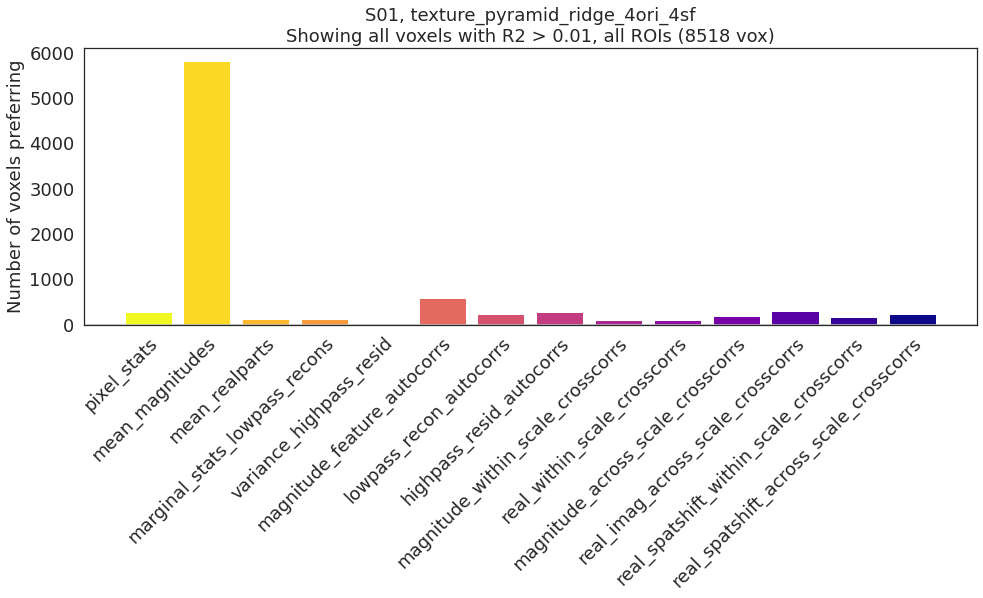

In [45]:
plot_utils.set_all_font_sizes(fs = 18)
r2_cutoff = 0.01

ff_inds = np.arange(15,29)
n_submodels = len(ff_inds)
n_feature_types = n_submodels

# Compute variance explained by each feature type - how well does the model without that feature type
# do, compared to the model with all features? 
# (subtract later columns from the first column)
var_expl = np.tile(np.expand_dims(val_r2[:,0], axis=1), [1,n_submodels]) - val_r2[:,ff_inds] 
max_ve  = np.argmax(var_expl, axis=1)
ve_names = ['Unique_' + out['partial_version_names'][ff][10:] \
                             for ff in ff_inds]

inds2use = out['val_r2'][:,0]>r2_cutoff

unvals = np.arange(0,n_feature_types)
counts = np.array([np.sum(np.logical_and(max_ve==ff, inds2use)) for ff in unvals])
counts = counts[np.newaxis,:]

ve_names = out['feature_info'][1]
colors = cm.plasma(np.linspace(0,1,len(ve_names)))
colors = np.flipud(colors)

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Number of voxels preferring', \
                 title='S%02d, %s\nShowing all voxels with R2 > %.2f, all ROIs (%d vox)'%(subject, fitting_type, \
                                                        r2_cutoff, np.sum(inds2use)), \
                                                        horizontal_line_pos=0, ylims=None)
bp.create(data=counts, new_fig=True)

plt.gcf().subplots_adjust(bottom=0.4)

if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'hist_highest_uniqvar_features_allrois.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'hist_highest_uniqvar_features_allrois.png'))


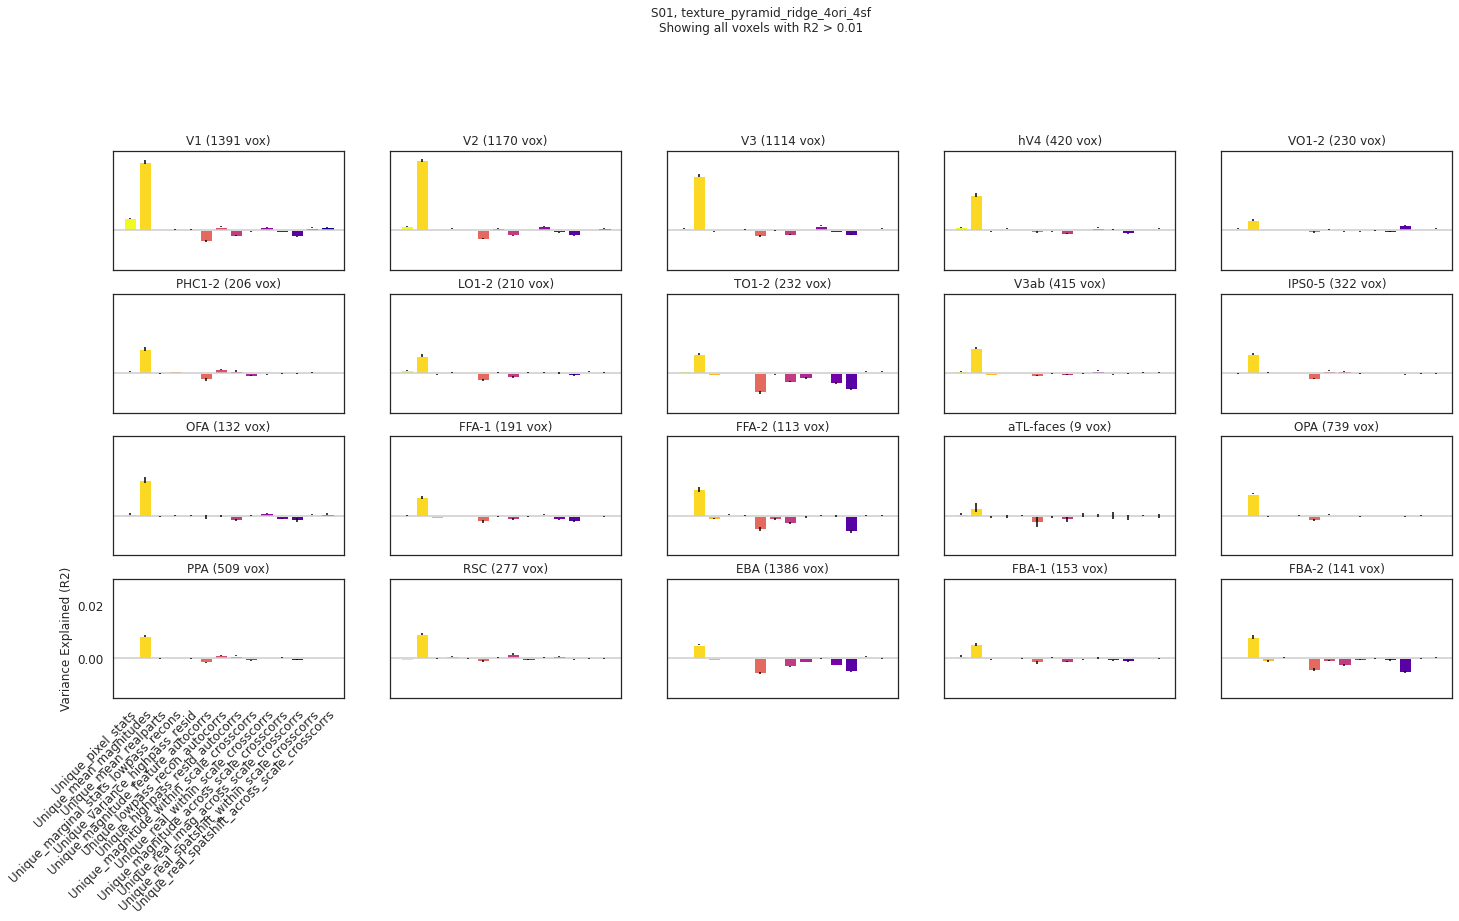

In [62]:
plot_utils.set_all_font_sizes(fs = 12)
r2_cutoff = 0.01
val_r2 = out['val_r2']

ff_inds = np.arange(15,29)
n_submodels = len(ff_inds)

var_expl = np.tile(np.expand_dims(val_r2[:,0], axis=1), [1,n_submodels]) - val_r2[:,ff_inds] 
ve_names = ['Unique_' + out['partial_version_names'][ff][10:] \
                             for ff in ff_inds]
# var_expl = np.concatenate([val_r2[:,0:1], var_expl], axis=1)
# ve_names = ['Full Model'] + ['Unique_' + out['partial_version_names'][ff][10:] \
#                              for ff in ff_inds]

colors = cm.plasma(np.linspace(0,1,len(ve_names)))
colors = np.flipud(colors)
# graycolor = np.array([0.6, 0.6, 0.6, 1])
# colors = np.concatenate((graycolor[np.newaxis,:], np.flipud(colors)), axis=0)

inds2use = val_r2[:,0]>r2_cutoff

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', plot_errorbars=True, \
                  horizontal_line_pos=0, ylims=[-0.015, 0.03])

plot_utils.create_roi_subplots(var_expl, inds2use, bp, subject, out, roi_def=roi_def, skip_inds=skip_inds, \
                    suptitle='S%02d, %s\nShowing all voxels with R2 > %.2f'%(subject, fitting_type, r2_cutoff))

plt.gcf().subplots_adjust(bottom=0.5)

if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_bars_texturefeat_eachroi.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_bars_texturefeat_eachroi.png'))

In [52]:
var_expl.shape

(19738, 14)

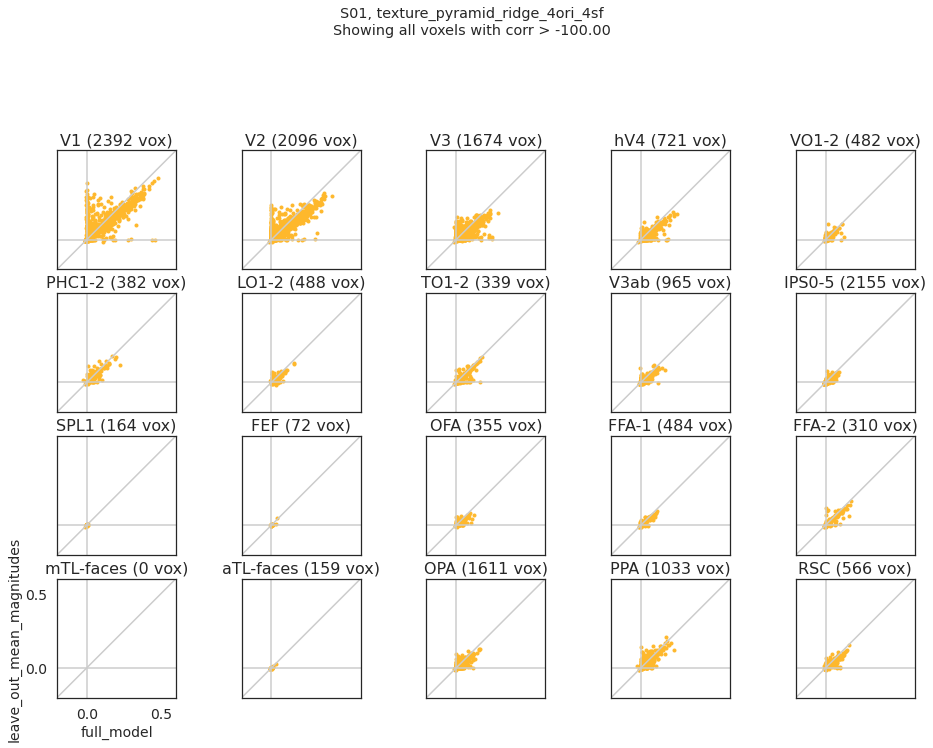

In [5]:
pp1=0
pp2=2

cc_cutoff = -100
val_r2 = analysis_utils.get_r2(out)

if len(out['best_params'])>6:
    partial_version_names = out['best_params'][6]
else:
    partial_version_names = out['partial_version_names']
        
colors = cm.plasma(np.linspace(0,1,len(out['feature_info'][1])))
colors = np.flipud(colors)
color = colors[pp2]

inds2use = out['val_cc'][:,0]>cc_cutoff

sp = plot_utils.scatter_plot(color=color, xlabel=partial_version_names[pp1], ylabel=partial_version_names[pp2], xlims=[-0.2, 0.6], ylims=[-0.2, 0.6], \
                  xticks=[0, 0.5], yticks=[0, 0.5],\
                 title='S%02d, %s\nShowing all voxels with corr > %.2f, all ROIs (%d vox)'%(subject, fitting_type, \
                                                        cc_cutoff, np.sum(inds2use)), \
                                                        show_diagonal=True, show_axes=True);
plot_utils.create_roi_subplots(val_r2[:,[pp1, pp2]], inds2use, sp, subject, out,\
                                      suptitle='S%02d, %s\nShowing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff),\
                                      label_just_corner=True, figsize=(16,20))

plt.gcf().subplots_adjust(bottom=0.5)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'compare_%s_vs_%s_scatter_eachroi.pdf'%(partial_version_names[pp1], partial_version_names[pp2])))
    plt.savefig(os.path.join(fig_save_folder,'compare_%s_vs_%s_scatter_eachroi.png'%(partial_version_names[pp1], partial_version_names[pp2])))